In [1]:
# ============================================================
# M-GW: Pairwise Alignment of Spatiotemporal Mouse Embryo Slices
# ============================================================

import scanpy as sc
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import util, models, plotting, geometry
from mgw import pullback_metric_field, knn_graph
from mgw.gw import solve_gw_ott
import importlib
import matplotlib.pyplot as plt
import os

# ----------------------------
# Runtime & device setup
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Input files & parameters
# ----------------------------
filehandles_embryo_adata = [
    '/scratch/gpfs/ph3641/mouse_embryo/E9.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E10.5_E1S1.MOSTA.h5ad'
]
timepoints = ['E9.5', 'E10.5']

# Embedding / network parameters
PCA_comp   = 30
CCA_comp   = 3
knn_k      = 12
geodesic_eps = 0.01

gw_params = dict(verbose=True, inner_maxit=3000, outer_maxit=3000,
                 inner_tol=1e-7, outer_tol=1e-7, epsilon=1e-4)

save_dir = "/scratch/gpfs/ph3641/mgw/ME_Alignments"
os.makedirs(save_dir, exist_ok=True)

# ============================================================
# 1. Load datasets and prepare
# ============================================================
print('Loading AnnData slices...')
adatas = []
for i, fh in enumerate(filehandles_embryo_adata):
    adata = sc.read_h5ad(fh)
    adata.X = adata.layers['count']
    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]
    adatas.append(adata)

# Intersect genes across all slices
common_genes = list(set.intersection(*[set(a.var_names) for a in adatas]))
adatas = [a[:, common_genes] for a in adatas]
print(f"Common genes: {len(common_genes)}")


Device: cuda
Loading AnnData slices...
Common genes: 24040


In [2]:
# ============================================================
# 2. Loop over consecutive pairs (E11.5→E12.5, E12.5→E13.5)
# ============================================================
importlib.reload(geometry)

for i in range(len(adatas)-1):
    ad1, ad2 = adatas[i], adatas[i+1]
    tp1, tp2 = timepoints[i], timepoints[i+1]
    print(f"\n--- Aligning {tp1} → {tp2} ---")
    
    # Normalization, log1p, PCA
    joint = ad.concat([ad1, ad2], join='inner')
    sc.pp.normalize_total(joint)
    sc.pp.log1p(joint)
    sc.pp.pca(joint, n_comps=PCA_comp)
    
    # Split back into slices
    A = joint[joint.obs['timepoint'] == tp1].copy()
    B = joint[joint.obs['timepoint'] == tp2].copy()
    
    # Ensure spatial coords exist
    xs = np.asarray(A.obsm["spatial"], dtype=float)
    xs2 = np.asarray(B.obsm["spatial"], dtype=float)
    xs_n = util.normalize_coords_to_unit_square(xs)
    xs2_n = util.normalize_coords_to_unit_square(xs2)
    
    # ========================================================
    # (a) Feature preprocessing (PCA + CCA "feeler")
    # ========================================================
    
    results = util.project_informative_features(path_X=None, path_Z=None,
        adata_X=A, adata_Z=B, PCA_comp=PCA_comp, CCA_comp=CCA_comp,
        n_downsample=8000
    )
    
    ys, ys2 = results["X_cca_full"], results["Z_cca_full"]
    Y, Y2 = results["X_pca"], results["Z_pca"]
    
    #Y, Y2 = np.asarray(A.obsm['X_pca'][:, :PCA_comp]), np.asarray(B.obsm['X_pca'][:, :PCA_comp])
    #ys, ys2=Y, Y2
    
    # ========================================================
    # (b) Train neural fields φ, ψ : (coords)->(features)
    # ========================================================
    xs_t, xs2_t = torch.from_numpy(xs_n).to(device), torch.from_numpy(xs2_n).to(device)
    
    #ys_t = torch.from_numpy(Y).to(device=device, dtype=xs_t.dtype)
    ys_t = util.normalize_range(torch.from_numpy(ys).to(device)) #<--- CCA not needed, unimodal!
    #ys2_t = torch.from_numpy(Y2).to(device=device, dtype=xs_t.dtype)
    ys2_t = util.normalize_range(torch.from_numpy(ys2).to(device))
    
    dim_e, dim_f_M, dim_f_N = 2, ys_t.shape[1], ys2_t.shape[1]
    print("dims:", dim_e, dim_f_M, dim_f_N)

    '''
    if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy")):
        
        phi = models.PhiModel(dim_e, dim_f_M, widths=(128,256,256,128)).to(device)
        psi = models.PhiModel(dim_e, dim_f_N, widths=(128,256,256,128)).to(device)
        
        phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=10000, print_every=1000, device=device)
        psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=10000, print_every=1000, device=device)
        phi.eval(); psi.eval()
        
        from mgw.plotting import fit_metrics
        rng = np.random.default_rng(0)
        for k in rng.choice(dim_f_M, size=min(2, dim_f_M), replace=False):
            X_pred = plotting.predict_on_model(phi, xs_n)
            plotting.plot_fit_on_cloud(xs, ys_t[:,k].cpu().numpy(), X_pred[:,k],
                                       title_true=f'ST feat{k} (true)', title_pred=f'φ(xs) feat{k} (pred)')
            print('φ feat', k, fit_metrics(ys_t[:,k].cpu().numpy(), X_pred[:,k]))
            Z_pred = plotting.predict_on_model(psi, xs2_n)
            plotting.plot_fit_on_cloud(xs2, ys2_t[:,k].cpu().numpy(), Z_pred[:,k],
                                       title_true=f'SM feat{k} (true)', title_pred=f'ψ(xs2) feat{k} (pred)')
            print('ψ feat', k, fit_metrics(ys2_t[:,k].cpu().numpy(), Z_pred[:,k]))
        
        # ========================================================
        # (c) Compute pull-back metric fields & geodesics
        # ========================================================
        print("Computing metric fields")
        
        #G_M = pullback_metric_field(phi, torch.from_numpy(xs_n).to(device), eps=geodesic_eps).cpu()
        #G_N = pullback_metric_field(psi, torch.from_numpy(xs2_n).to(device), eps=geodesic_eps).cpu()
        G_M = geometry.pullback_metric_field(phi, torch.from_numpy(xs_n).to(device), eps=geodesic_eps).cpu()
        G_N = geometry.pullback_metric_field(psi, torch.from_numpy(xs2_n).to(device), eps=geodesic_eps).cpu()
        
        Gs = knn_graph(xs_n,  k=knn_k)
        Gt = knn_graph(xs2_n, k=knn_k)
        
        print("Computing geodesic distances")
        D_M = geometry.geodesic_distances_fast(xs_n, G_M, Gs)
        D_N = geometry.geodesic_distances_fast(xs2_n, G_N, Gt)
        
        def norm_geod(D):
            D = np.maximum(D, 0.0)
            np.fill_diagonal(D, 0.0)
            q = np.quantile(D[np.triu_indices_from(D, 1)], 0.99)
            return D/(q + 1e-12)
        
        D_Mn, D_Nn = norm_geod(D_M), norm_geod(D_N)
        C_M, C_N = D_Mn**2, D_Nn**2
        C_M = C_M / C_M.max()
        C_N = C_N / C_N.max()
        
        # ========================================================
        # (d) Solve Gromov-Wasserstein alignment
        # ========================================================
        print("Solving GW...")
        P = solve_gw_ott(C_M, C_N, **gw_params)
        print(f"Coupling shape: {P.shape}, mass={P.sum():.3f}")
        np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy"), P)
        
        # ========================================================
        # (e) Visualization
        # ========================================================
        print("Visualizing alignment...")
        plotting.plot_alignment_lines_dense(xs_n, xs2_n, P, alpha=0.05, lw=0.05)'''
        


--- Aligning E9.5 → E10.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
PCA shapes -> X: (5913, 30) Z: (18408, 30)
Feeler GW sizes: X-side 5913, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈3.6704e-03
Computing CCA Components
CCA dims: 3  (applied to full sets)
dims: 2 3 3


In [3]:

ys_t = util.normalize_range(torch.from_numpy(ys).to(device))
ys2_t = util.normalize_range(torch.from_numpy(ys2).to(device))

phi = models.PhiModel(dim_e, 3, widths=(128,256,256,128)).to(device)
psi = models.PhiModel(dim_e, 3, widths=(128,256,256,128)).to(device)

phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=10000, print_every=1000, device=device)
psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=10000, print_every=1000, device=device)
phi.eval(); psi.eval()


[train_phi] step=1000 loss=0.178231
[train_phi] step=2000 loss=0.139874
[train_phi] step=3000 loss=0.125249
[train_phi] step=4000 loss=0.116827
[train_phi] step=5000 loss=0.111307
[train_phi] step=6000 loss=0.108199
[train_phi] step=7000 loss=0.105354
[train_phi] step=8000 loss=0.101761
[train_phi] step=9000 loss=0.098960
[train_phi] step=10000 loss=0.116583
[train_phi] step=1000 loss=0.605988
[train_phi] step=2000 loss=0.570803
[train_phi] step=3000 loss=0.572948
[train_phi] step=4000 loss=0.547139
[train_phi] step=5000 loss=0.544580
[train_phi] step=6000 loss=0.538974
[train_phi] step=7000 loss=0.529685
[train_phi] step=8000 loss=0.527076
[train_phi] step=9000 loss=0.525241
[train_phi] step=10000 loss=0.525376


PhiModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Softplus(beta=1.0, threshold=20.0)
    (8): Linear(in_features=128, out_features=3, bias=True)
  )
)

Rescaling Jacobians by 177.04119684968092.
Rescaling Jacobians by 173.06331578498623.


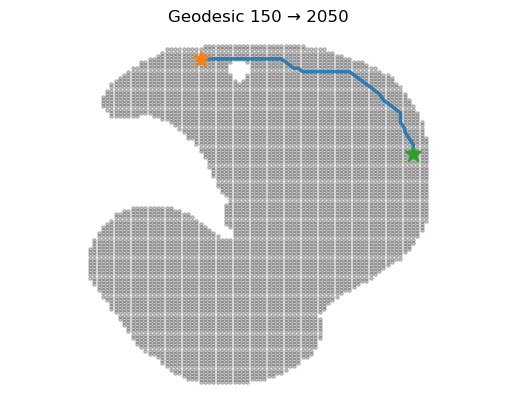

In [5]:
importlib.reload(plotting)

# Can use to tune eps for geodesics..

geodesic_eps = 0.1 #0 #.000000001

G_M = geometry.pullback_metric_field(phi, torch.from_numpy(xs_n).to(device), eps=geodesic_eps).cpu()
G_N = geometry.pullback_metric_field(psi, torch.from_numpy(xs2_n).to(device), eps=geodesic_eps).cpu()

Gs = knn_graph(xs_n,  k=knn_k)
Gt = knn_graph(xs2_n, k=knn_k)

W_M = plotting.build_weighted_graph(xs_n, G_M, Gs)         # build once

# pick any pair (i, j)
i, j = 150, 2050
_, pred = plotting.geodesics_from_source(W_M, i)             # O(|E| log |V|)
path, ok = plotting.traceback_path(pred, i, j)
plotting.plot_geodesic(xs_n, path, title=f'Geodesic {i} → {j}')


In [6]:
print("Computing geodesic distances")
D_M = geometry.geodesic_distances_fast(xs_n, G_M, Gs)
D_N = geometry.geodesic_distances_fast(xs2_n, G_N, Gt)

def norm_geod(D):
    D = np.maximum(D, 0.0)
    np.fill_diagonal(D, 0.0)
    q = np.quantile(D[np.triu_indices_from(D, 1)], 0.99)
    return D/(q + 1e-12)

D_Mn, D_Nn = norm_geod(D_M), norm_geod(D_N)
C_M, C_N = D_Mn**2, D_Nn**2
C_M = C_M / C_M.max()
C_N = C_N / C_N.max()

Computing geodesic distances


[OTT] GW  ε=1.00e-04  iters=-1  loss≈2.0617e-03
Coupling shape: (5913, 18408), mass=1.000
Visualizing alignment...


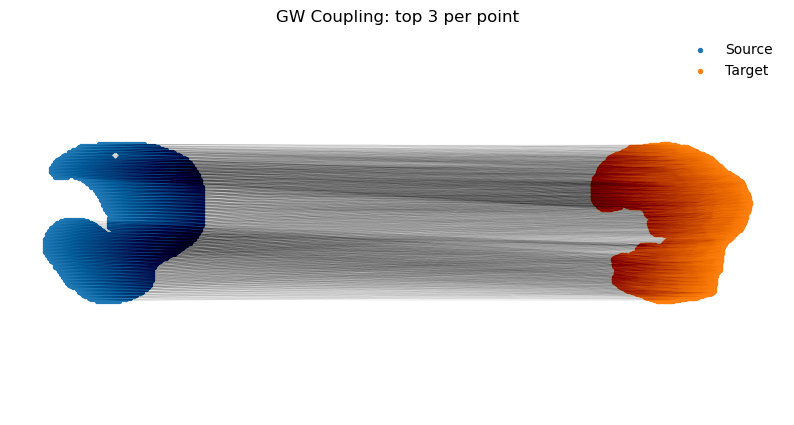

In [7]:
P = solve_gw_ott(C_M, C_N, **gw_params)
print(f"Coupling shape: {P.shape}, mass={P.sum():.3f}")
np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy"), P)

# ========================================================
# (e) Visualization
# ========================================================
print("Visualizing alignment...")
plotting.plot_alignment_lines_dense(xs_n, xs2_n, P, alpha=0.05, lw=0.05)


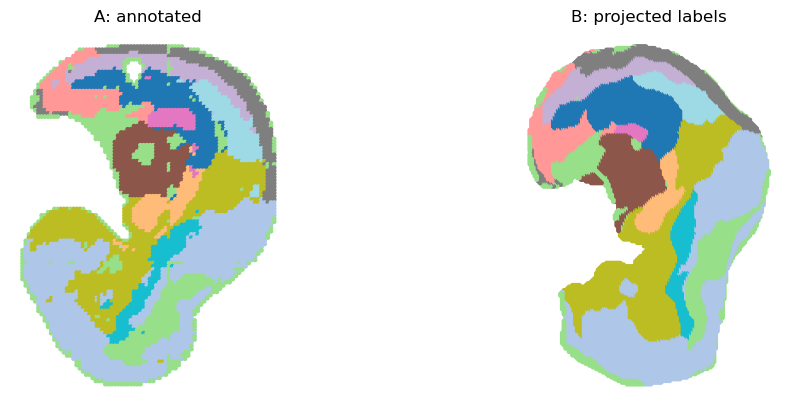

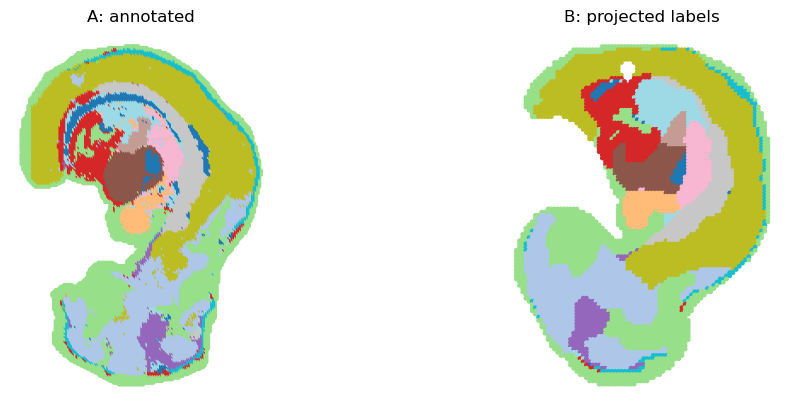

In [8]:

A_labels = A.obs['annotation'].to_numpy()
B_pred, B_conf, _ = plotting.project_labels_via_P(P, A_labels, direction="A_to_B")
# B_conf=B_conf
plotting.plot_projected_labels(A.obsm['spatial'], B.obsm['spatial'],
                      A_labels, B_pred, conf_thresh=0.5)

B_labels = B.obs['annotation'].to_numpy()
A_pred, A_conf, _ = plotting.project_labels_via_P(P.T, B_labels, direction="A_to_B")
# A_conf = A_conf
plotting.plot_projected_labels(B.obsm['spatial'], A.obsm['spatial'],
                      B_labels, A_pred, conf_thresh=0.5)


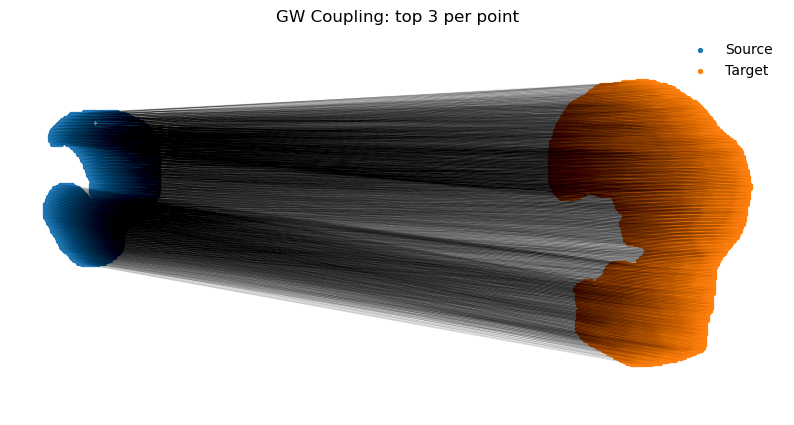

In [9]:
plotting.plot_alignment_lines_dense(xs, xs2, P, alpha=0.05, lw=0.2)

In [10]:
from mgw import metrics

metrics.expression_cosine_similarity(Y, Y2, P)

np.float32(-0.20463331)

In [11]:
metrics.migration_metrics(xs, xs2, P)

{'expected_disp_p': 898.7945097923963,
 'expected_disp': 29.979901764221914,
 'p': 2,
 'barycentric_drift_stats': {'mean': 26.57476982367612,
  'median': 26.48182112509724,
  'p90': 43.8321758260734,
  'p95': 46.53190318516667,
  'max': 56.50876472066509},
 'aligned_coords': {'S': array([[-13.58582618,  50.15270597],
         [-12.58582618,  50.15270597],
         [-11.58582618,  50.15270597],
         ...,
         [ -5.58582618, -55.84729403],
         [ -4.58582618, -55.84729403],
         [ -3.58582618, -55.84729403]]),
  'T': array([[ 69.46379211, -15.7777881 ],
         [ 68.97863618, -16.65221575],
         [ 68.49348025, -17.52664341],
         ...,
         [-50.04514393,  57.39060814],
         [-50.53029986,  56.51618048],
         [-51.01545579,  55.64175283]])}}

In [12]:
from scipy.spatial.distance import cdist

if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy")):
    # Spatial GW baseline
    C1_s  = cdist(xs_n, xs_n)**2
    C1 = C1_s / C1_s.max()
    C2_s  = cdist(xs2_n, xs2_n)**2
    C2 = C2_s / C2_s.max()
    P_s = solve_gw_ott(C1_s, C2_s, **gw_params)
    np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy"), P_s)
else:
    P_s = np.load(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy"))


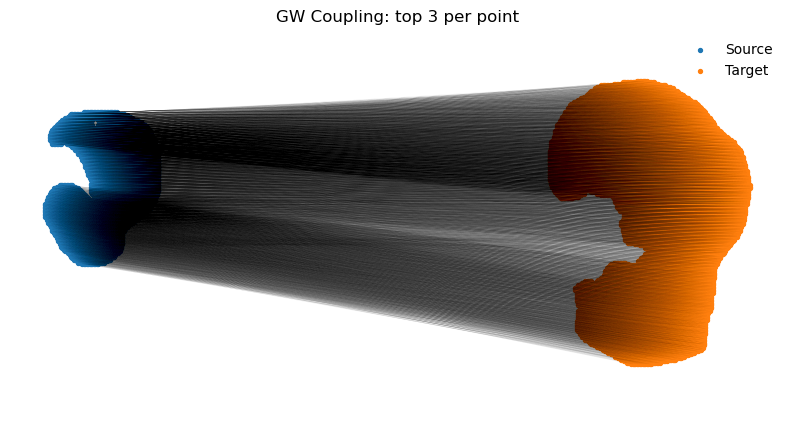

{'expected_disp_p': 842.228273910554,
 'expected_disp': 29.021169409769723,
 'p': 2,
 'barycentric_drift_stats': {'mean': 26.417891822984984,
  'median': 26.464899492733938,
  'p90': 42.2438445761006,
  'p95': 45.53536307718502,
  'max': 52.4321893059117},
 'aligned_coords': {'S': array([[-13.58583397,  50.15270681],
         [-12.58583397,  50.15270681],
         [-11.58583397,  50.15270681],
         ...,
         [ -5.58583397, -55.84729319],
         [ -4.58583397, -55.84729319],
         [ -3.58583397, -55.84729319]]),
  'T': array([[ 69.80003122, -14.30521555],
         [ 69.33223099, -15.18904978],
         [ 68.86443075, -16.07288401],
         ...,
         [-51.12995911,  56.48982267],
         [-51.59775935,  55.60598845],
         [-52.06555958,  54.72215422]])}}

In [13]:
plotting.plot_alignment_lines_dense(xs, xs2, P_s, alpha=0.05, lw=0.2)
metrics.expression_cosine_similarity(Y, Y2, P_s)
metrics.migration_metrics(xs, xs2, P_s)

In [14]:

if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy")):
    # Feature GW baseline
    C1_f  = cdist(Y, Y)**2
    C2_f  = cdist(Y2, Y2)**2
    C1_f = C1_f / C1_f.max()
    C2_f = C2_f / C2_f.max()
    P_f = solve_gw_ott(C1_f, C2_f, **gw_params)
    np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy"), P_f)
else:
    P_f = np.load(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy"))


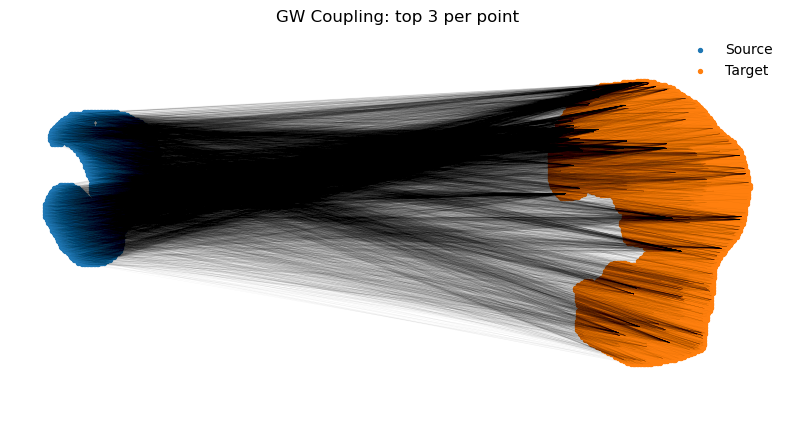

{'expected_disp_p': 5049.846688711208,
 'expected_disp': 71.06227331510868,
 'p': 2,
 'barycentric_drift_stats': {'mean': 31.791677299813166,
  'median': 32.86283236164461,
  'p90': 48.28102018657872,
  'p95': 51.51633506023716,
  'max': 84.22050915658735},
 'aligned_coords': {'S': array([[-13.5858279 ,  50.15271422],
         [-12.5858279 ,  50.15271422],
         [-11.5858279 ,  50.15271422],
         ...,
         [ -5.5858279 , -55.84728578],
         [ -4.5858279 , -55.84728578],
         [ -3.5858279 , -55.84728578]]),
  'T': array([[-65.63114084, -27.68951546],
         [-65.74692836, -26.69624146],
         [-65.86271587, -25.70296745],
         ...,
         [ 74.12194511, -17.43890733],
         [ 74.00615759, -16.44563332],
         [ 73.89037008, -15.45235932]])}}

In [15]:
plotting.plot_alignment_lines_dense(xs, xs2, P_f, alpha=0.05, lw=0.2)
metrics.expression_cosine_similarity(Y, Y2, P_f)
metrics.migration_metrics(xs, xs2, P_f)

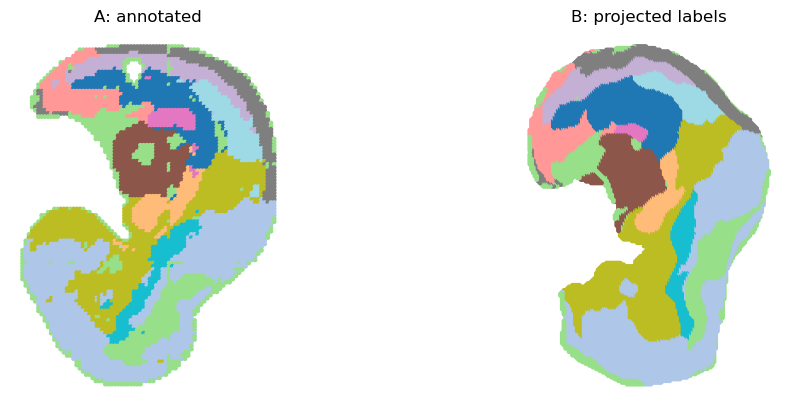

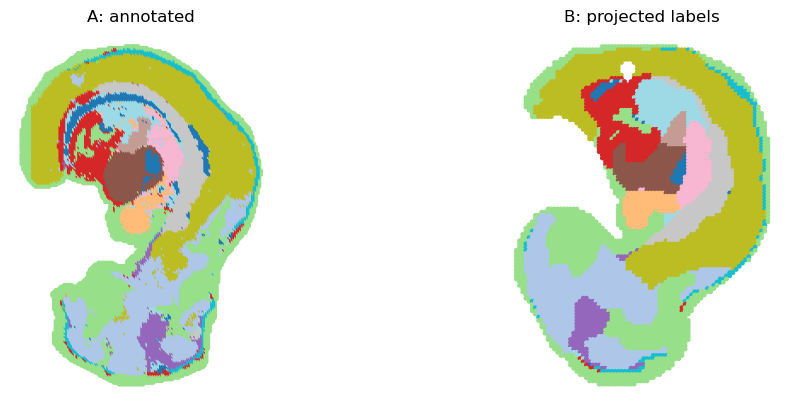

In [46]:
importlib.reload(plotting)

A_labels = A.obs['annotation'].to_numpy()
B_pred, B_conf, _ = plotting.project_labels_via_P(P, A_labels, direction="A_to_B")
# B_conf=B_conf
plotting.plot_projected_labels(A.obsm['spatial'], B.obsm['spatial'],
                      A_labels, B_pred, conf_thresh=0.5)

B_labels = B.obs['annotation'].to_numpy()
A_pred, A_conf, _ = plotting.project_labels_via_P(P.T, B_labels, direction="A_to_B")
# A_conf = A_conf
plotting.plot_projected_labels(B.obsm['spatial'], A.obsm['spatial'],
                      B_labels, A_pred, conf_thresh=0.5)

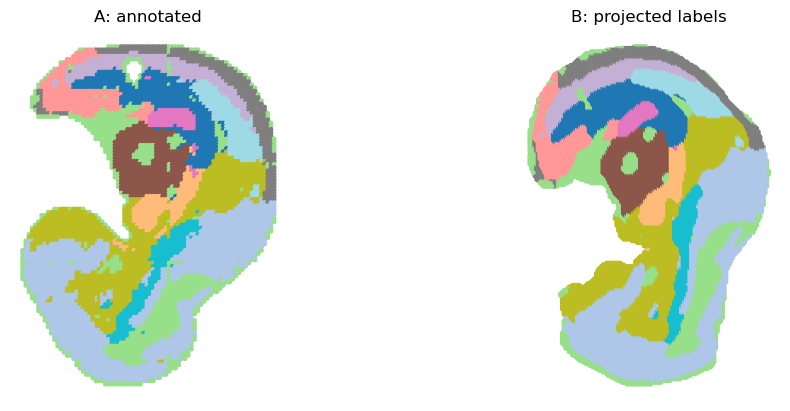

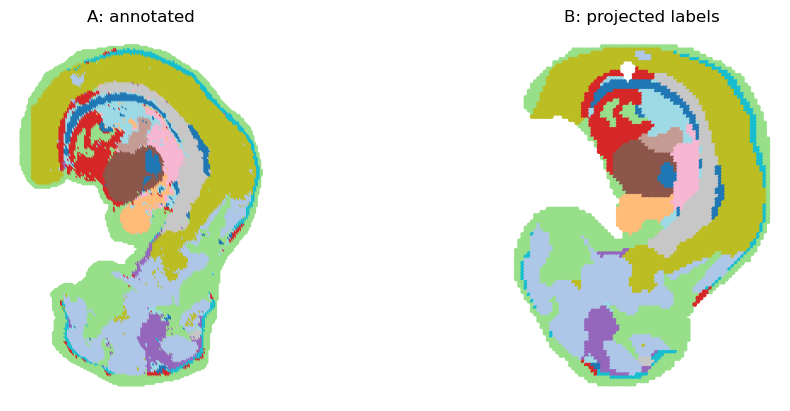

In [47]:

A_labels = A.obs['annotation'].to_numpy()
B_pred, B_conf, _ = plotting.project_labels_via_P(P_s, A_labels, direction="A_to_B")
# B_conf=B_conf
plotting.plot_projected_labels(A.obsm['spatial'], B.obsm['spatial'],
                      A_labels, B_pred, conf_thresh=0.5)

B_labels = B.obs['annotation'].to_numpy()
A_pred, A_conf, _ = plotting.project_labels_via_P(P_s.T, B_labels, direction="A_to_B")
# A_conf = A_conf
plotting.plot_projected_labels(B.obsm['spatial'], A.obsm['spatial'],
                      B_labels, A_pred, conf_thresh=0.5)


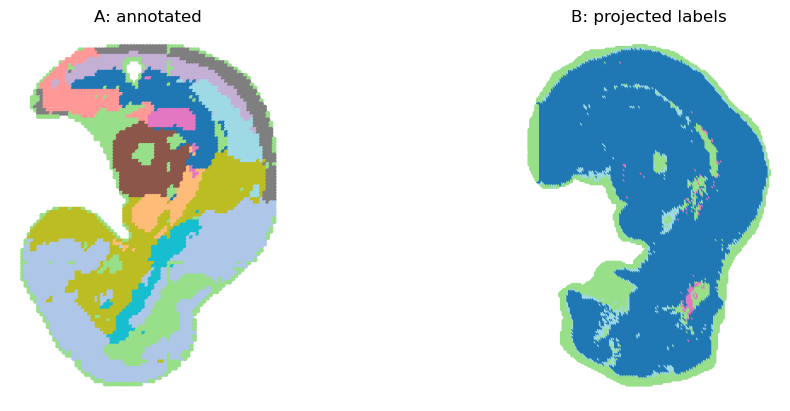

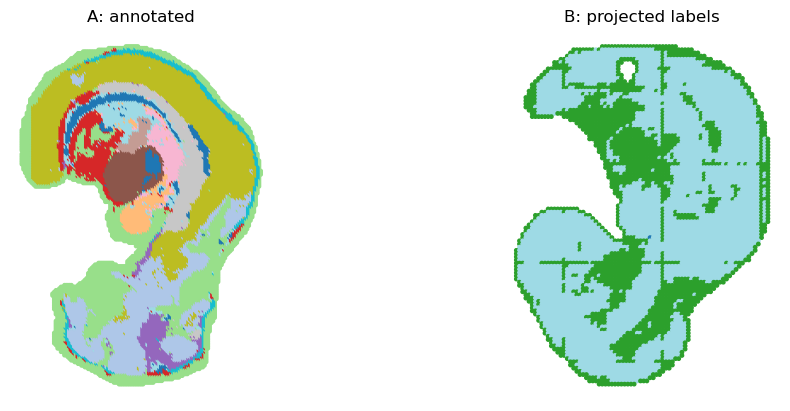

In [48]:

A_labels = A.obs['annotation'].to_numpy()
B_pred, B_conf, _ = plotting.project_labels_via_P(P_f, A_labels, direction="A_to_B")
# B_conf=B_conf
plotting.plot_projected_labels(A.obsm['spatial'], B.obsm['spatial'],
                      A_labels, B_pred, conf_thresh=0.5)

B_labels = B.obs['annotation'].to_numpy()
A_pred, A_conf, _ = plotting.project_labels_via_P(P_f.T, B_labels, direction="A_to_B")
# A_conf = A_conf
plotting.plot_projected_labels(B.obsm['spatial'], A.obsm['spatial'],
                      B_labels, A_pred, conf_thresh=0.5)


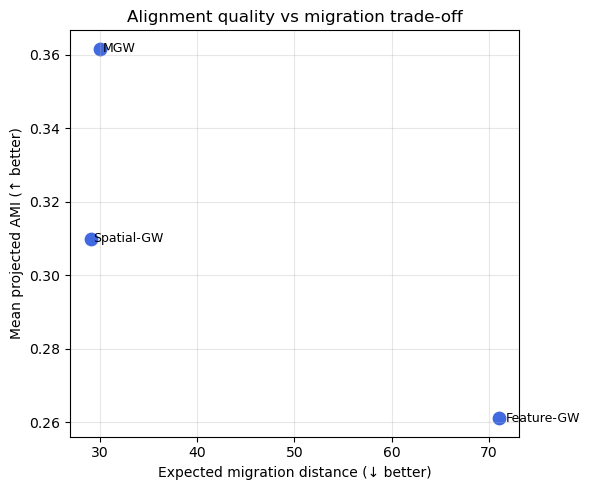

{'names': ['MGW', 'Spatial-GW', 'Feature-GW'], 'migration': [29.979901764221914, 29.021169409769723, 71.06227331510868], 'projAMI_mean': [0.3615544238632673, 0.3098543697251529, 0.2611155826767727]}


In [53]:
importlib.reload(plotting)
importlib.reload(metrics)

summary = plotting.summarize_alignment(
    couplings=[P, P_s, P_f],
    names=["MGW", "Spatial-GW", "Feature-GW"],
    xs=xs, xs2=xs2,
    A_labels=A.obs['annotation'].to_numpy(),
    B_labels=B.obs['annotation'].to_numpy()
)

print(summary)

In [39]:
# Project A→B and score
projAB = ami_on_projected_labels(P, A.obs['annotation'].to_numpy(),
                                    B.obs['annotation'].to_numpy())

print("Projected A→B  AMI:", projAB["AMI"], " ARI:", projAB["ARI"], " ACC:", projAB["ACC"])

# Project B to A and score
projBA = ami_on_projected_labels(P.T, B.obs['annotation'].to_numpy(),
                                    A.obs['annotation'].to_numpy())
print("Projected B→A  AMI:", projBA["AMI"], " ARI:", projBA["ARI"], " ACC:", projBA["ACC"])


Projected A→B  AMI: 0.3400570273459395  ARI: 0.20644819964931324  ACC: 0.5306199005908281
Projected B→A  AMI: 0.3830518203805951  ARI: 0.251989985264769  ACC: 0.5619628500138619


In [40]:
# Project A to B and score
projAB = ami_on_projected_labels(P_s, A.obs['annotation'].to_numpy(),
                                    B.obs['annotation'].to_numpy(),
                                    conf_thresh=0.5)
print("Projected A→B  AMI:", projAB["AMI"], " ARI:", projAB["ARI"], " ACC:", projAB["ACC"])

B_pred_eval = projAB["B_pred_eval"]
B_conf_eval = projAB["B_conf_eval"]
keep = projAB["keep_mask_B_common"]

# Project B to A and score
projBA = ami_on_projected_labels(P_s.T, B.obs['annotation'].to_numpy(),
                                    A.obs['annotation'].to_numpy())
print("Projected B→A  AMI:", projBA["AMI"], " ARI:", projBA["ARI"], " ACC:", projBA["ACC"])


Projected A→B  AMI: 0.2862901148013727  ARI: 0.19054861141789822  ACC: 0.5171827794561934
Projected B→A  AMI: 0.33536658763776683  ARI: 0.225369642305922  ACC: 0.518436373717771


In [41]:
# Project A to B and score
projAB = ami_on_projected_labels(P_f, A.obs['annotation'].to_numpy(),
                                    B.obs['annotation'].to_numpy(),
                                    conf_thresh=0.5)
print("Projected A→B  AMI:", projAB["AMI"], " ARI:", projAB["ARI"], " ACC:", projAB["ACC"])

B_pred_eval = projAB["B_pred_eval"]
B_conf_eval = projAB["B_conf_eval"]
keep = projAB["keep_mask_B_common"]

# Project B to A and score
projBA = ami_on_projected_labels(P_f.T, B.obs['annotation'].to_numpy(),
                                    A.obs['annotation'].to_numpy())
print("Projected A→B  AMI:", projBA["AMI"], " ARI:", projBA["ARI"], " ACC:", projBA["ACC"])


Projected A→B  AMI: 0.38477338611416045  ARI: 0.27151507747555553  ACC: 0.6578755911240451
Projected A→B  AMI: 0.32330707191288255  ARI: 0.30760143983505206  ACC: 0.5980038813418354


In [ ]:

mig1 = metrics.migration_metrics(xs, xs2, P)['expected_disp']
mig2 = metrics.migration_metrics(xs, xs2, P_s)['expected_disp']
mig3 = metrics.migration_metrics(xs, xs2, P_f)['expected_disp']

# Project A→B and score
projAB = ami_on_projected_labels(P, A.obs['annotation'].to_numpy(),
                                    B.obs['annotation'].to_numpy())

print("Projected A→B  AMI:", projAB["AMI"], " ARI:", projAB["ARI"], " ACC:", projAB["ACC"])

# Project B to A and score
projBA = ami_on_projected_labels(P.T, B.obs['annotation'].to_numpy(),
                                    A.obs['annotation'].to_numpy())
print("Projected B→A  AMI:", projBA["AMI"], " ARI:", projBA["ARI"], " ACC:", projBA["ACC"])

